# LASSI Data Analysis Pipeline V2
This is an updated attempt to create a pipeline that illustrates how one would take Leica scanner data and produce commands to the Active Surface Manager that would compensate for any detected surface deformations.
The parts of this pipeline that need work we'll mark in <font color='red'>red TODOs</font>. 

In [1]:
%matplotlib notebook

## Step One: Get some Leica data for a reference and signal scan

We are still unclear on how we are going to do this for production.  What we are currently using as input 
are PTX files (human readable) that were produced by Leica employees (using in part at least, the Cyclone software).  
Copies of these files can be in: /home/sandboxes/pmargani/LASSI/data.

<font color='red'>TODO:</font> we need understand, and perhaps replicate how these PTX files were generated. 

The files are further processed by our own Mathematica code that was adapted from some of Fred's work.  
This code does a simple Affine Transform, and filters out things like the header and data that is past a certain 
distance from the scanner.  It can also optionally take a random sample of the PTX data to avoid working with the full data set.

It will write the final output to a file name of your choosing.

The source for this can be found here: /home/sandboxes/pmargani/LASSI/data/LeicaP40demo/Aug2016/myZfit5Part1.m

<font color='red'>TODO:</font> we should convert this Mathematica script to python.



## Step Two: Smooth this Data

Warning: this is the computationally expensive part!  We've already done this step, which takes about 10 hours for 
each scan, so we highly recommend you don't run this commented code, and instead use the dumps we made of this smoothing to file.

<font color='red'>TODO:</font> we need to find a way to make this processing faster by this summer (2019).


In [2]:
# Don't run this!  For 512x512, using ALL the data (not a random sampling)
# this could take 10 hours for each scan
# from main import *
#n = 512
#fn1 = "data/randomSampleSta10.csv"
#x1, y1, z1 = smoothSpherical(fn1, n)
#fn2 = "data/randomSampleBumpScan14.csv"
#x2, y2, z2 = smoothSpherical(fn2, n)

# instead the smoothed data can be found here:
# fn1 = "data/BumpScan.csv.smoothed.sig.001.all.npz"
# fn = "data/Baseline_STA10_HIGH_METERS.csv.smoothed.sig.001.all.npz"

## Step Three: Fit this data to parabolas
We'll leverage our parabolas module to do the heavy lifting here.
See also the 'Parabolas' and 'Show me the Bumps' Notebooks.

<font color='red'>TODO:</font> The code in parabolas.py does not seem to work well with simulated data.  We need to follow up on this.


<IPython.core.display.Javascript object>


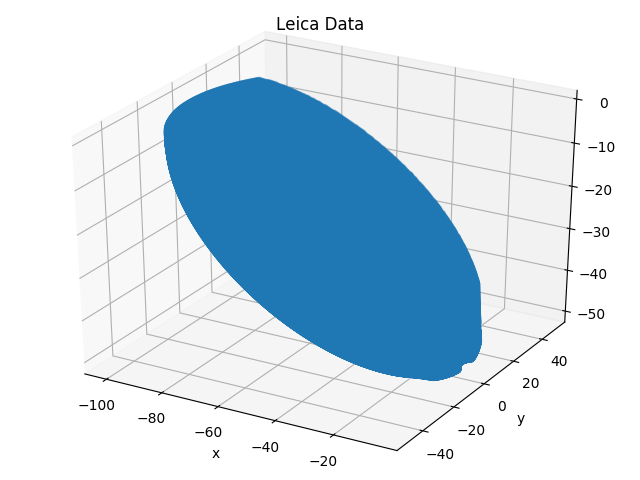

cleaned data fitted with coefficients:  [ 5.74103781e+01  2.83446831e-01 -2.22812997e+00 -4.91790425e+01
  1.52363084e-03 -3.31406173e-02]


<IPython.core.display.Javascript object>


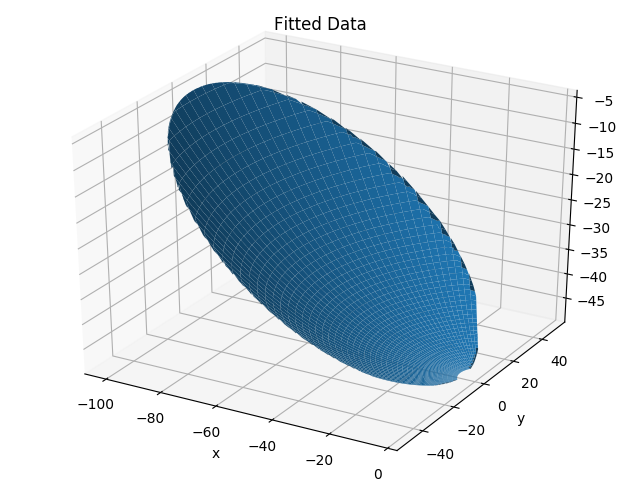

<IPython.core.display.Javascript object>


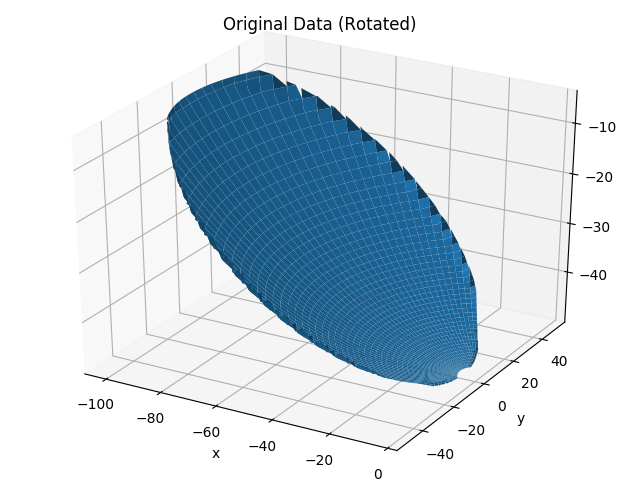

<IPython.core.display.Javascript object>


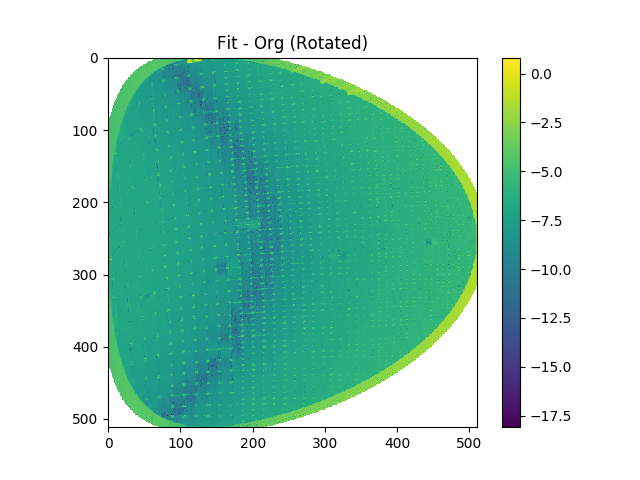

In [3]:
from parabolas import *
fn = "data/Baseline_STA10_HIGH_METERS.csv.smoothed.sig.001.all.npz"
refDiff = fitLeicaScan(fn)

<IPython.core.display.Javascript object>


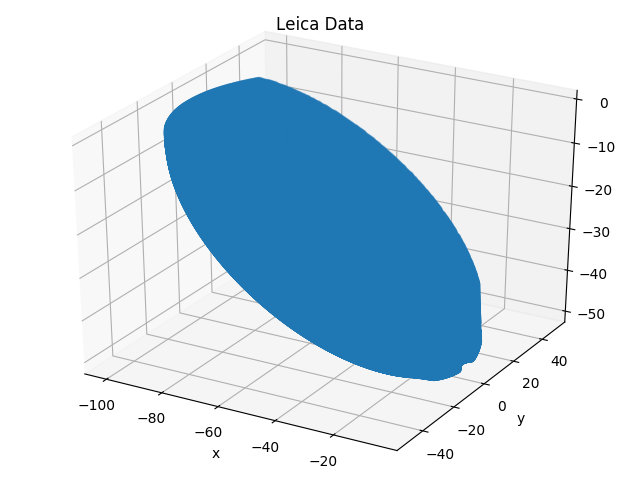

cleaned data fitted with coefficients:  [ 5.74057936e+01  2.87607672e-01 -2.22277309e+00 -4.91783029e+01
  1.43187879e-03 -3.30739821e-02]


<IPython.core.display.Javascript object>


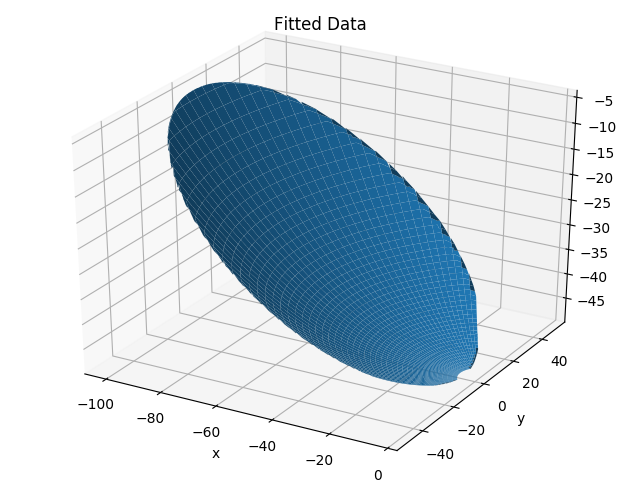

<IPython.core.display.Javascript object>


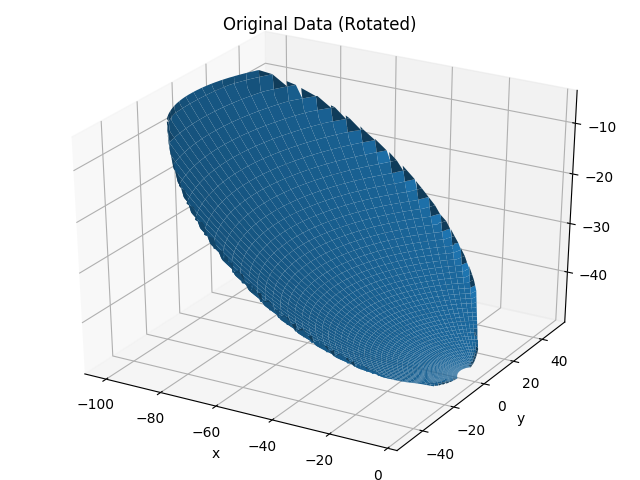

<IPython.core.display.Javascript object>


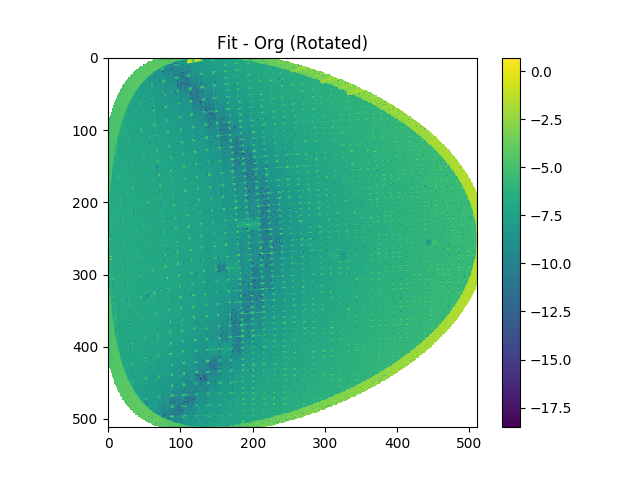

In [4]:
fn = "data/BumpScan.csv.smoothed.sig.001.all.npz"
bumpDiff = fitLeicaScan(fn)

## Step Four: Find the Deformations
Also known as, 'Show me the Bumps'.  This step is conceptually simple: we just find the difference between our reference and signal scan.  We break it out in a separate step here for dramatic affect.

<IPython.core.display.Javascript object>


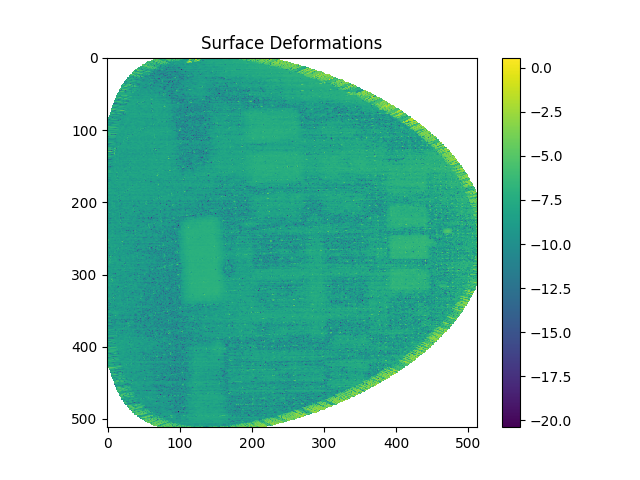

In [5]:
diffData = refDiff - bumpDiff
diffDataLog = np.log(np.abs(diffData))
imagePlot(diffDataLog, "Surface Deformations")

## Step Five:  Fit Zernikes to this surface
This is identical to what we did in the first version of our pipeline.  But note, that we're still not sure that we want to do this on this data: we probably need to rotate this surface somehow to be in the correct plane for the Active Surface.

<font color='red'>TODO:</font> Determine correct reference frame to fit Zernikes in.

<IPython.core.display.Javascript object>


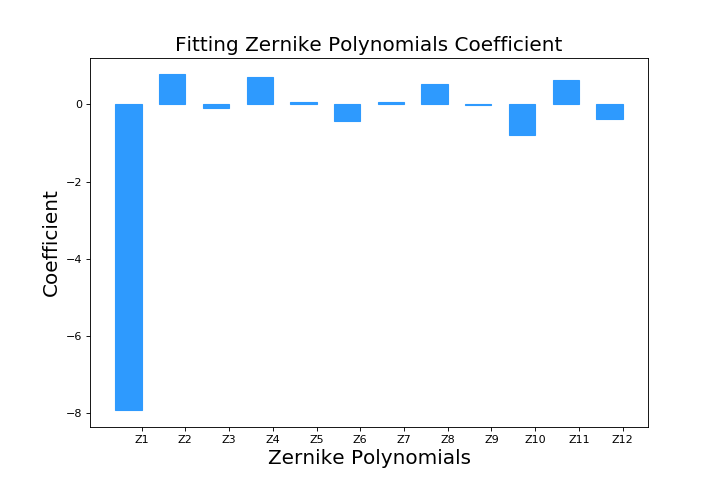

<IPython.core.display.Javascript object>


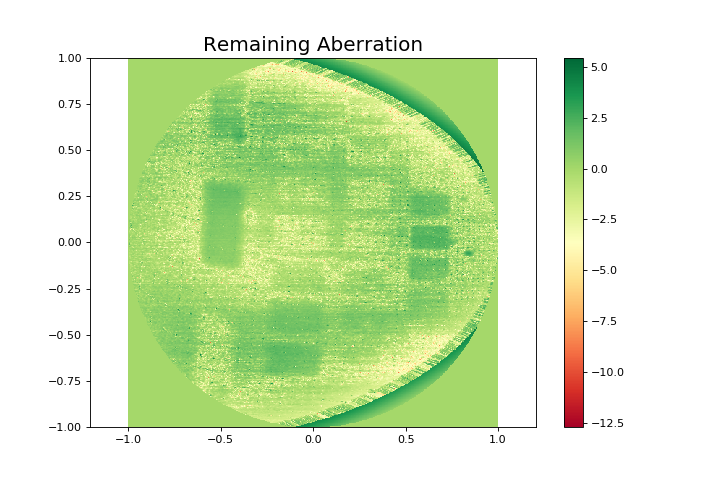

                            Zernike Polynomials List                              
----------------------------------------------------------------------------------
|   Z1  |   Z2  |   Z3  |   Z4  |   Z5  |   Z6  |   Z7  |   Z8  |   Z9  |  Z10  |
----------------------------------------------------------------------------------
| 0.000 | 0.779 |-0.079 | 0.713 | 0.070 |-0.441 | 0.068 | 0.521 |-0.018 |-0.783 |
----------------------------------------------------------------------------------
|  Z11  |  Z12  |  Z13  |  Z14  |  Z15  |  Z16  |  Z17  |  Z18  |  Z19  |  Z20  |
----------------------------------------------------------------------------------
| 0.628 |-0.379 | 0.000 | 0.000 | 0.000 | 0.000 | 0.000 | 0.000 | 0.000 | 0.000 |
----------------------------------------------------------------------------------
|  Z21  |  Z22  |  Z23  |  Z24  |  Z25  |  Z26  |  Z27  |  Z28  |  Z29  |  Z30  |
----------------------------------------------------------------------------------
| 0.000 |

<IPython.core.display.Javascript object>


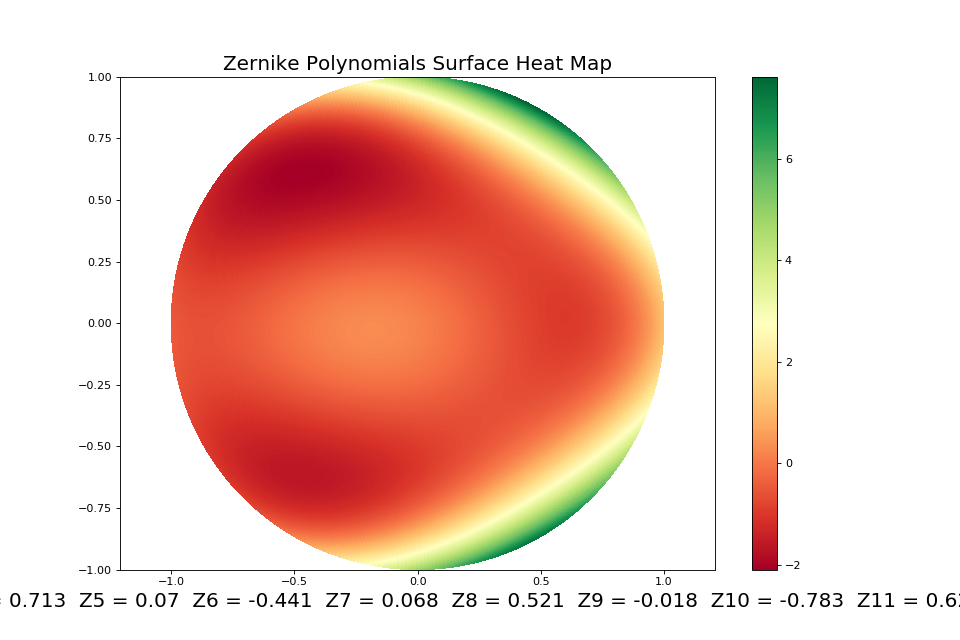

Z2 =  0.779 Z11 x Tilt
Z3 =  -0.079 Z11 y Tilt
Z4 =  0.713 Z20 Defocus
Z5 =  0.07 Z22 Primary Astigmatism at 45
Z6 =  -0.441 Z22 Primary Astigmatism at 0
Z7 =  0.068 Z31 Primary y Coma
Z8 =  0.521 Z31 Primary x Coma
Z9 =  -0.018 Z33 y Trefoil
Z10 =  -0.783 Z33 x Trefoil
Z11 =  0.628 Z40 Primary Spherical
Z12 =  -0.379 Z42 Secondary Astigmatism at 0


In [7]:
import opticspy
from copy import copy
import numpy as np

# replace NaNs with zeros
diffDataOrg = copy(diffData)
diffDataLog[np.isnan(diffDataLog)] = 0.

# find the first 12 Zernike terms
fitlist,C1 = opticspy.zernike.fitting(diffDataLog,
                                      12,
                                      remain2D=1,
                                      barchart=1)
print "fitlist: ", fitlist
C1.listcoefficient()
C1.zernikemap()

## Step Six: Convert the coefficients from Noll to ANSI
Recall that opticspy works in Noll notation, while the Active Surface Manager seems to work in a modified version of ANSI (offset by one, phase rotated by 90 degrees).
Whether this is the only conversion needed to be done is another remaining open question.  It also depends on whether we did any compensation on 'diffData' before we fit the zernikes.

<font color='red'>TODO:</font> finish understanding in what plane the zernikes should be in.

## Step Seven: Send these Coefficients to the Active Surface Manager

The Active Surface Manager has the zernike_coeff parameter (indexes 1 through N).  When these are set, the manager can use them to compute the displacement of each individual actuator.
